# **Spark HW2 Movie Recommendation**

In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in MovieLens small dataset: https://grouplens.org/datasets/movielens/latest/

# **Part 0: Data ETL and Data Exploration**

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q http://apache.forsale.plus/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!ls
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!wget -q http://apache.mirrors.pair.com/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [40.1 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nv

In [2]:
# set up spark

!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init("spark-3.0.1-bin-hadoop2.7") # SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 204kB 2.7MB/s 
/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory



In [3]:
# !ls

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
movies_df = spark.read.load("drive/My Drive/movie_rec_small/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("drive/My Drive/movie_rec_small/ratings.csv", format='csv', header = True)
links_df = spark.read.load("drive/My Drive/movie_rec_small/links.csv", format='csv', header = True)
tags_df = spark.read.load("drive/My Drive/movie_rec_small/tags.csv", format='csv', header = True)

In [35]:
movies_pd = movies_df.toPandas()
ratings_pd = ratings_df.toPandas()

In [7]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [8]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [9]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [10]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [11]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
tmp3 = ratings_df.groupBy("userID").count().toPandas()['count'].mean()
tmp4 = ratings_df.groupBy("movieId").count().toPandas()['count'].mean()

print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))
print('Average number of ratings per user is {}'.format(tmp1))
print('Average number of ratings per movie is {}'.format(tmp1))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1
Average number of ratings per user is 20
Average number of ratings per movie is 20


# **Part 1: Spark SQL and OLAP**

In [12]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

**1. Number of users**

In [13]:
q1_result=spark.sql("Select Count(Distinct userId) as Number_of_Users from ratings")
q1_result.show()

+---------------+
|Number_of_Users|
+---------------+
|            610|
+---------------+



**2. Number of Movies**
**and number of movies not rated**

In [14]:
q2_result=spark.sql("Select Count(movieId) as Number_of_Movies from movies")
q2_result.show()

+----------------+
|Number_of_Movies|
+----------------+
|            9742|
+----------------+



In [15]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] <= 5)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by fewer than 5 users'.format(tmp1, tmp2))

6456 out of 9724 movies are rated by fewer than 5 users


In [16]:
no_rating=spark.sql("Select Count(movieId) as Movies_Not_Rated From movies Where movieID not in (Select movieId From ratings)")
no_rating.show()

+----------------+
|Movies_Not_Rated|
+----------------+
|              18|
+----------------+



In [17]:
movies_no_rating=spark.sql("Select movieId, title From movies Where movieID not in (Select movieId From ratings)")
movies_no_rating.toPandas()

,movieId,title
0,1076,"Innocents, The (1961)"
1,2939,Niagara (1953)
2,3338,For All Mankind (1989)
3,3456,"Color of Paradise, The (Rang-e khoda) (1999)"
4,4194,I Know Where I'm Going! (1945)
5,5721,"Chosen, The (1981)"
6,6668,"Road Home, The (Wo de fu qin mu qin) (1999)"
7,6849,Scrooge (1970)
8,7020,Proof (1991)
9,7792,"Parallax View, The (1974)"


**3. All movie genres**


In [18]:
q3_result=spark.sql("Select Distinct explode(split(genres,'[|]')) as genres From movies Order by 1")
q3_result.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



**4. Number of movies in each genre**

In [19]:
q4_result_1=spark.sql(
    "Select genres,Count(movieId) as Number_of_Movies From (Select explode(split(genres,'[|]')) as genres, movieId From movies) Group By 1 Order by 2 DESC")
q4_result_1.show()

+------------------+----------------+
|            genres|Number_of_Movies|
+------------------+----------------+
|             Drama|            4361|
|            Comedy|            3756|
|          Thriller|            1894|
|            Action|            1828|
|           Romance|            1596|
|         Adventure|            1263|
|             Crime|            1199|
|            Sci-Fi|             980|
|            Horror|             978|
|           Fantasy|             779|
|          Children|             664|
|         Animation|             611|
|           Mystery|             573|
|       Documentary|             440|
|               War|             382|
|           Musical|             334|
|           Western|             167|
|              IMAX|             158|
|         Film-Noir|              87|
|(no genres listed)|              34|
+------------------+----------------+



**5. Number of ratings**

In [20]:
q5_result=spark.sql("Select Count(*) as Number_of_Ratings from ratings")
q5_result.show()

+-----------------+
|Number_of_Ratings|
+-----------------+
|           100836|
+-----------------+



**6. Number of movies in each tag, show only top 20 results**

In [21]:
q6_result_1=spark.sql("Select tag, Count(movieId) as Number_of_Movies From tags Group By 1 Order by 2 DESC")
q6_result_1.show(20)

+------------------+----------------+
|               tag|Number_of_Movies|
+------------------+----------------+
|  In Netflix queue|             131|
|       atmospheric|              36|
|         superhero|              24|
| thought-provoking|              24|
|            Disney|              23|
|             funny|              23|
|           surreal|              23|
|          religion|              22|
|       dark comedy|              21|
|            quirky|              21|
|        psychology|              21|
|            sci-fi|              21|
|          suspense|              20|
|visually appealing|              19|
|      twist ending|              19|
|             crime|              19|
|          politics|              18|
|             music|              16|
|       time travel|              16|
|    mental illness|              16|
+------------------+----------------+
only showing top 20 rows



**7. Making a word cloud: most popular genres**

In [31]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [37]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies_pd['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1

#______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies_pd, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

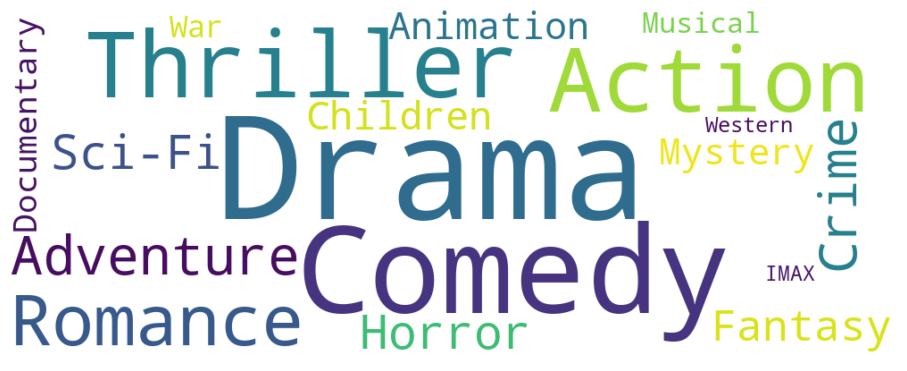

In [38]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# **Part 2: Content-Based Filtering: similar movies based on genre**

Content-based filtering using tf-idf and pairwise cosine similarity between each pair of genres. This algorithm doesn't utilize any user information.

#1. TF-IDF 

In [39]:
# Break up the big genre string into a string array
movies_pd['genres'] = movies_pd['genres'].str.split('|')
# Convert genres to string value
movies_pd['genres'] = movies_pd['genres'].fillna("").astype('str')

In [40]:
# transforms text to feature vectors that can be used as input to estimator

from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_pd['genres'])
tfidf_matrix.shape

(9742, 177)

#2. Cosine Similarity 

In [41]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.31379419, 0.0611029 , 0.05271111],
       [0.31379419, 1.        , 0.        , 0.        ],
       [0.0611029 , 0.        , 1.        , 0.35172407],
       [0.05271111, 0.        , 0.35172407, 1.        ]])

In [53]:
# Build a 1-dimensional array with movie titles
titles = movies_pd['title']
indices = pd.Series(movies_pd.index, index=movies_pd['title'])

# Function that get top 10 movie recommendations 
# based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [54]:
genre_recommendations("White Chicks (2004)")

672                              Bulletproof (1996)
1366                            Big Hit, The (1998)
2730                              Rent-A-Cop (1988)
3390                                     K-9 (1989)
3730                 All About the Benjamins (2002)
3850                             Bad Company (2002)
3870                        V. I. Warshawski (1991)
4008                        Knockaround Guys (2002)
4312    Flickering Lights (Blinkende lygter) (2000)
4533                                   Kuffs (1992)
Name: title, dtype: object

In [56]:
genre_recommendations("Usual Suspects, The (1995)")

826                         Dial M for Murder (1954)
828                            Reservoir Dogs (1992)
831                            Basic Instinct (1992)
1250                               Switchback (1997)
1945                                Following (1998)
3329                                  Frantic (1988)
3991                               Red Dragon (2002)
5294         Sherlock Holmes: Terror by Night (1946)
5296    Sherlock Holmes and the Secret Weapon (1942)
5337             Murder on the Orient Express (1974)
Name: title, dtype: object

# **Part 3: Collaborative Filtering with Spark ALS**

Using Spark ALS to predict ratings and recommend movies to users, based on the rate records of similar users

#1. Model selection and fit on training data
  * finding optimal hyperparameters

In [22]:
ratings=ratings_df.drop('timestamp')

ratings = ratings.withColumn("userId", ratings["userId"].cast("Integer"))
ratings = ratings.withColumn("movieId", ratings["movieId"].cast("Integer"))
ratings = ratings.withColumn("rating", ratings["rating"].cast("float"))

In [23]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)



In [24]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [25]:
# split ratings to train and test sets: 0.8 to 0.2 ratio
(training,test)=ratings.randomSplit([0.8,0.2])

training.cache()
test.cache()

DataFrame[userId: int, movieId: int, rating: float]

In [58]:
#Create ALS model
model = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", seed = 10)

In [59]:
#Tune model using ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(model.regParam, [0.05, 0.1, 0.3, 0.5])
             .addGrid(model.rank, [5, 10, 15])
             .addGrid(model.maxIter, [1, 5, 10])
             .build())

In [60]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [61]:
# Build Cross validation 
cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [62]:
#Fit ALS model to training data
cvModel = cv.fit(training)

In [63]:
bestModel=cvModel.bestModel

In [64]:
bestModel.itemFactors

DataFrame[id: int, features: array<float>]

#2. Best model on testing data
And finally, make a prediction and check the testing error.

In [65]:
#Generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

In [66]:
#Print evaluation metrics and model parameters
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank: ", str(bestModel._java_obj.parent().getRank())),
print (" MaxIter: ", str(bestModel._java_obj.parent().getMaxIter())), 
print (" RegParam: ", str(bestModel._java_obj.parent().getRegParam()))

RMSE = 0.8729728871980146
**Best Model**
 Rank:  15
 MaxIter:  10
 RegParam:  0.1


In [67]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   133|    471|   4.0| 3.2199824|
|   436|    471|   3.0| 3.4962656|
|   462|    471|   2.5| 2.6060169|
|   448|    471|   4.0| 3.2678735|
|    32|    471|   3.0| 3.8956025|
|   608|    471|   1.5| 3.1934154|
|   357|    471|   3.5| 4.1492114|
|    47|   1088|   4.0| 2.8956957|
|   474|   1088|   3.5| 3.0210986|
|   563|   1088|   4.0| 3.3486934|
|   489|   1088|   4.5| 3.5836878|
|   381|   1088|   3.5| 3.5458105|
|    84|   1088|   3.0| 3.1667936|
|   509|   1088|   3.0| 3.2384422|
|   188|   1088|   4.0|  3.122719|
|   525|   1088|   4.5|  3.329955|
|   600|   1088|   3.5|  2.068213|
|   385|   1238|   3.0|  3.974226|
|   325|   1342|   4.0| 2.6580384|
|   312|   1342|   4.0| 2.2590995|
+------+-------+------+----------+
only showing top 20 rows



#3. Apply model on the entire dataset and analyze the performance

In [68]:
alldata=bestModel.transform(ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.6083010766050813


In [69]:
alldata.registerTempTable("alldata")

In [70]:
spark.sql("Select * From alldata").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   191|    148|   5.0| 4.9322586|
|   133|    471|   4.0| 3.2199824|
|   597|    471|   2.0| 3.4132044|
|   385|    471|   4.0| 3.4856412|
|   436|    471|   3.0| 3.4962656|
|   602|    471|   4.0| 3.6250837|
|    91|    471|   1.0| 2.2505853|
|   409|    471|   3.0| 3.2440617|
|   372|    471|   3.0| 3.5341592|
|   599|    471|   2.5|  2.874425|
|   603|    471|   4.0| 3.4639006|
|   182|    471|   4.5|  4.248295|
|   218|    471|   4.0| 3.5022643|
|   474|    471|   3.0|  3.292134|
|   500|    471|   1.0| 1.8774328|
|    57|    471|   3.0| 3.4616573|
|   462|    471|   2.5| 2.6060169|
|   387|    471|   3.0| 3.0406647|
|   610|    471|   4.0| 3.4041977|
|   217|    471|   2.0| 2.6539414|
+------+-------+------+----------+
only showing top 20 rows



In [71]:
spark.sql("select * from movies join alldata on movies.movieId=alldata.movieId").show()

+-------+--------------------+------+------+-------+------+----------+
|movieId|               title|genres|userId|movieId|rating|prediction|
+-------+--------------------+------+------+-------+------+----------+
|    148|Awfully Big Adven...| Drama|   191|    148|   5.0| 4.9322586|
|    471|Hudsucker Proxy, ...|Comedy|   133|    471|   4.0| 3.2199824|
|    471|Hudsucker Proxy, ...|Comedy|   597|    471|   2.0| 3.4132044|
|    471|Hudsucker Proxy, ...|Comedy|   385|    471|   4.0| 3.4856412|
|    471|Hudsucker Proxy, ...|Comedy|   436|    471|   3.0| 3.4962656|
|    471|Hudsucker Proxy, ...|Comedy|   602|    471|   4.0| 3.6250837|
|    471|Hudsucker Proxy, ...|Comedy|    91|    471|   1.0| 2.2505853|
|    471|Hudsucker Proxy, ...|Comedy|   409|    471|   3.0| 3.2440617|
|    471|Hudsucker Proxy, ...|Comedy|   372|    471|   3.0| 3.5341592|
|    471|Hudsucker Proxy, ...|Comedy|   599|    471|   2.5|  2.874425|
|    471|Hudsucker Proxy, ...|Comedy|   603|    471|   4.0| 3.4639006|
|    4

In [72]:
print('Recommended top users (e.g. 1 top user) for all items with the corresponding predicted ratings:')
bestModel.recommendForAllItems(1).show(5)

print('-'*50)

print('Recommended top items (e.g. 1 top item) for all users with the corresponding predicted ratings:')
bestModel.recommendForAllUsers(1).show(5)

Recommended top users (e.g. 1 top user) for all items with the corresponding predicted ratings:
+-------+------------------+
|movieId|   recommendations|
+-------+------------------+
|   1580|  [[53, 5.012784]]|
|   4900| [[413, 4.603004]]|
|   5300|[[375, 4.0721674]]|
|   6620| [[375, 4.918841]]|
|   7340|[[337, 3.9569652]]|
+-------+------------------+
only showing top 5 rows

--------------------------------------------------
Recommended top items (e.g. 1 top item) for all users with the corresponding predicted ratings:
+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[177593, 4.75732...|
|   463|[[78836, 4.7160673]]|
|   496| [[2843, 4.5622883]]|
|   148|[[183897, 4.54388...|
|   540|  [[3379, 5.251795]]|
+------+--------------------+
only showing top 5 rows



#4. Recommend movies to selected users (by userID)

In [74]:
pip install pyarrow==2.0.*

     |████████████████████████████████| 17.7MB 1.4MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [104]:
from pyspark.sql.functions import lit

# recommend N movies to a random user
def recommendMovies(model, user, nbRecommendations):

  # Create a Spark DataFrame with the specified user and all the movies listed in the ratings DataFrame
  dataSet = ratings.select('movieId').distinct().withColumn('userId', lit(user))

  # Create a Spark DataFrame with the movies that have already been rated by this user
  moviesAlreadyRated = ratings.filter(ratings.userId == user).select('movieId', 'userId')

  # Apply the recommender system to the dataset without the already rated movies to predict ratings
  predictions = bestModel.transform(dataSet.subtract(moviesAlreadyRated)).
  dropna().orderBy('prediction', ascending=False).limit(nbRecommendations).select('movieId', 'prediction')
    
  # Join with the movies DataFrame to get the movies titles and genres
  recommendations = predictions.join(movies_df, predictions.movieId == movies_df.movieId).select(
      predictions.movieId, movies_df.title, movies_df.genres, predictions.prediction)

  # recommendations.show(truncate=False)
  return recommendations

In [105]:
# 10 Recommendations to user 10
recommendMovies(bestModel, 10, 10).toPandas()

,movieId,title,genres,prediction
0,1962,Driving Miss Daisy (1989),Drama,4.362336
1,3061,Holiday Inn (1942),Comedy|Musical,4.218753
2,3086,Babes in Toyland (1934),Children|Comedy|Fantasy|Musical,4.384491
3,3685,Prizzi's Honor (1985),Comedy|Drama|Romance,4.322546
4,4857,Fiddler on the Roof (1971),Drama|Musical,4.467036
5,7034,Show Me Love (Fucking Åmål) (1998),Drama|Romance,4.312288
6,26614,"Bourne Identity, The (1988)",Action|Adventure|Drama|Mystery|Thriller,4.510836
7,86320,Melancholia (2011),Drama|Sci-Fi,4.263542
8,161582,Hell or High Water (2016),Crime|Drama,4.649501
9,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi,4.895617


In [106]:
# Recommendations to user 471
recommendMovies(bestModel, 471, 10).toPandas()

,movieId,title,genres,prediction
0,2398,Miracle on 34th Street (1947),Comedy|Drama,4.502142
1,3088,Harvey (1950),Comedy|Fantasy,4.479091
2,7096,Rivers and Tides (2001),Documentary,4.504360
3,26928,"Summer's Tale, A (Conte d'été) (1996)",Comedy|Drama|Romance,4.440796
4,74226,"Dream of Light (a.k.a. Quince Tree Sun, The) (...",Documentary|Drama,4.440796
5,78836,Enter the Void (2009),Drama,4.476496
6,86237,Connections (1978),Documentary,4.440796
7,92475,All Watched Over by Machines of Loving Grace (...,Documentary,4.488190
8,171495,Cosmos,(no genres listed),4.440796
9,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.757327
